## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch.utils.data import Dataset, TensorDataset
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

In [2]:
def data_transform(X, y_hat=None):
    
    if y_hat is not None:
        #DATA
        # Convert to numpy.ndarray and change shape to chanel x size x size
        X = X.values.reshape(-1,1,28,28)
        # Convert numpy.ndarrray to torch tensor
        X = torch.from_numpy(X)
        # Normalize step 1  change to [0 to 1]
        X = torch.true_divide(X, 255)
        # Normalize step 2 change to [-1 to 1]
        X = torch.true_divide((X - 0.5), 0.5)

        # LABELS
        # Transform to Tensor
        y_hat = torch.from_numpy(y_hat.values)
        y_hat.type(torch.LongTensor)
    
        return X, y_hat
    
    else:
        # DATA
        # Convert to numpy.ndarray and change shape to chanel x size x size
        X = X.values.reshape(-1,1,28,28)
        # Convert numpy.ndarrray to torch tensor
        X = torch.from_numpy(X)
        # Normalize step 1  change to [0 to 1]
        X = torch.true_divide(X, 255)
        # Normalize step 2 change to [-1 to 1]
        X = torch.true_divide((X - 0.5), 0.5)
        
        return X    

In [3]:
data_train = pd.read_csv("data/train.csv")
data_test = pd.read_csv("data/test.csv")

In [4]:
data_train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

## Split data to valid and train data

In [5]:
X_raw = data_train.drop(columns=["label"])
y_raw = data_train["label"]

X_train, X_valid, y_train, y_valid = train_test_split(X_raw, y_raw, test_size=0.20, random_state=42)

## Transform data

In [6]:
X_train_transform, y_train_transform = data_transform(X=X_train, y_hat=y_train)
X_valid_transform, y_valid_transform = data_transform(X=X_valid, y_hat=y_valid)

X_test_transform = data_transform(data_test)

## Create TensorDataset and DataLoader

In [7]:
batch_size = 32

data_train = torch.utils.data.TensorDataset(X_train_transform, y_train_transform)
data_valid = torch.utils.data.TensorDataset(X_valid_transform, y_valid_transform)

loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size)
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size=batch_size)


data_test = torch.utils.data.TensorDataset(X_test_transform)
loader_test = torch.utils.data.DataLoader(data_test)

## Create NN Model

In [8]:
class MyNNModel(nn.Module):
    def __init__(self):
        super(MyNNModel, self).__init__()
        
        # 28x28x1
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        # 14x14x16
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # 7x7x32
        #self.conv3 = nn.Conv2d(16, 64, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        # deep of last Conv2d and 
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 10)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 32 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x     

In [9]:
model = MyNNModel()

if torch.cuda.is_available():
    model.cuda()

print(model)

MyNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Specify Loss and Optimizer

In [10]:
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)
criterion = nn.NLLLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.003)

## Training the Network

In [11]:
epochs = 90
valid_loss_min = np.Inf
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

train_losses = []
valid_losses = []

for epoch in range(1, epochs+1):
    
    # track loss
    loss_train = 0.0
    loss_valid = 0.0
    
    # enable model to train not evaluate (turn on dropout)
    model.train() 
    for pic, target in loader_train:
        if torch.cuda.is_available():
            pic, target = pic.cuda(), target.cuda()
        #clear gradient    
        optimizer.zero_grad()
        output = model(pic)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()*pic.size(0)
    

    # enable model to evaluate not train (turn off dropout)
    model.eval()
    # disable calculation gradient
    with torch.no_grad():
        for pic, target in loader_valid:
           
            if torch.cuda.is_available():
                pic, target = pic.cuda(), target.cuda()
            
            output = model(pic)
            loss = criterion(output, target)
            loss_valid += loss.item()*pic.size(0)
            
            _, pred = torch.max(output, 1)
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            
            for i in range(len(target)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
            
    loss_train = loss_train/len(loader_train.sampler)
    loss_valid = loss_valid/len(loader_valid.sampler)
    
    train_losses.append(loss_train)
    valid_losses.append(loss_valid)

    print(f"Epoch: {epoch} \tTraining Loss: {loss_train:.6f}"
          f"\tValidation Loss: {loss_valid:.6f}")
    
    # save model if validation loss has decreased
    if loss_valid <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min:.6f} --> {loss_valid:.6f})."
              "Saving model ...")
        torch.save(model, "data/model_MNIST_epoch90_SGD_002.pt")
        valid_loss_min = loss_valid
        
# # Print sumary
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Epoch: 1 	Training Loss: 2.169466	Validation Loss: 1.825376
Validation loss decreased (inf --> 1.825376).Saving model ...


C:\Users\janya\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MyNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2 	Training Loss: 1.110605	Validation Loss: 0.566748
Validation loss decreased (1.825376 --> 0.566748).Saving model ...
Epoch: 3 	Training Loss: 0.546234	Validation Loss: 0.385160
Validation loss decreased (0.566748 --> 0.385160).Saving model ...
Epoch: 4 	Training Loss: 0.428308	Validation Loss: 0.313938
Validation loss decreased (0.385160 --> 0.313938).Saving model ...
Epoch: 5 	Training Loss: 0.359904	Validation Loss: 0.269806
Validation loss decreased (0.313938 --> 0.269806).Saving model ...
Epoch: 6 	Training Loss: 0.311376	Validation Loss: 0.236580
Validation loss decreased (0.269806 --> 0.236580).Saving model ...
Epoch: 7 	Training Loss: 0.277198	Validation Loss: 0.211786
Validation loss decreased (0.236580 --> 0.211786).Saving model ...
Epoch: 8 	Training Loss: 0.243445	Validation Loss: 0.191822
Validation loss decreased (0.211786 --> 0.191822).Saving model ...
Epoch: 9 	Training Loss: 0.224200	Validation Loss: 0.174080
Validation loss decreased (0.191822 --> 0.174080).S

Epoch: 68 	Training Loss: 0.046807	Validation Loss: 0.041504
Epoch: 69 	Training Loss: 0.046155	Validation Loss: 0.041562
Epoch: 70 	Training Loss: 0.045170	Validation Loss: 0.040377
Validation loss decreased (0.041105 --> 0.040377).Saving model ...
Epoch: 71 	Training Loss: 0.044475	Validation Loss: 0.040150
Validation loss decreased (0.040377 --> 0.040150).Saving model ...
Epoch: 72 	Training Loss: 0.044712	Validation Loss: 0.040208
Epoch: 73 	Training Loss: 0.043988	Validation Loss: 0.039815
Validation loss decreased (0.040150 --> 0.039815).Saving model ...
Epoch: 74 	Training Loss: 0.043757	Validation Loss: 0.039166
Validation loss decreased (0.039815 --> 0.039166).Saving model ...
Epoch: 75 	Training Loss: 0.042413	Validation Loss: 0.039183
Epoch: 76 	Training Loss: 0.041893	Validation Loss: 0.038639
Validation loss decreased (0.039166 --> 0.038639).Saving model ...
Epoch: 77 	Training Loss: 0.042013	Validation Loss: 0.038622
Validation loss decreased (0.038639 --> 0.038622).Savin

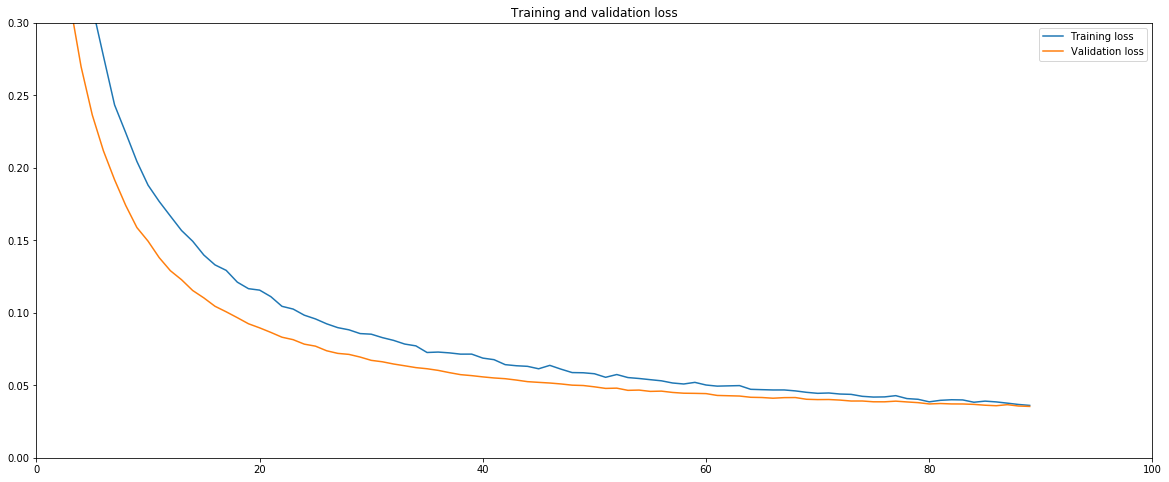

In [12]:
plt.figure(figsize=(20,8))
plt.title("Training and validation loss")
plt.axis([0, 100, 0, 0.3])
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.show()

## Load model

In [13]:
model = torch.load("data/model_MNIST_epoch90_SGD_002.pt")
model = MyNNModel()

if torch.cuda.is_available():
    model.cuda()

print(model)

MyNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


## Predict data

In [14]:
labels = []
model.eval()
with torch.no_grad():
    # we must get into list
    for pic in loader_test:
        pic = pic[0]
        
        if torch.cuda.is_available():
            pic = pic.cuda()
        
        output = model(pic)
        labels.append(torch.argmax(torch.exp(output).data).item())

## Create submission Dataframe

In [15]:
len(labels)

28000

In [16]:
submission_dict = {'ImageId':list(range(1,len(loader_test.sampler) + 1)),'Label':labels}
df_submission = pd.DataFrame.from_dict(submission_dict)

In [17]:
df_submission['Label'].unique()

array([4, 1, 7], dtype=int64)

tensor([[1]])
tensor([[[[0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000]],

         [[0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
          [0.0000],
    

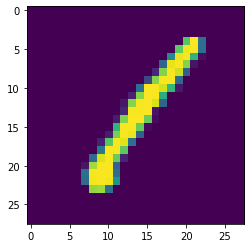

In [116]:
# for pic, label in trainloader:
#     print(label)
#     print(pic)
#     plt.figure()
#     image_array = pic
#     plt.imshow(image_array.reshape(28,28))
#     plt.show()
#     break

In [ ]:
# image_array = X_train_norm[0]
# plt.imshow(image_array.reshape(28,28), cmap='gray')
# plt.show()